<a href="https://colab.research.google.com/github/A7mita/PartialEmbedding/blob/main/Parallelembedding_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

üöÄ All-to-All vs All-Reduce Communication Patterns
üéØ INTERACTIVE DEMONSTRATION
This notebook shows the key differences between All-Reduce and All-to-All
with visual examples and real PyTorch code!

üîÑ ALL-REDUCE OPERATION
üìä Initial gradients on each GPU:


Param_1  Param_2  Param_3
GPU_0      1.0      2.0      0.5
GPU_1      3.0      1.5      2.0
GPU_2      0.5      3.0      1.0
GPU_3      2.0      0.5      2.5


‚úÖ After ALL-REDUCE (SUM):
üìã Result on ALL GPUs: [6.5, 7.0, 6.0]


<Figure size 1200x600 with 0 Axes>

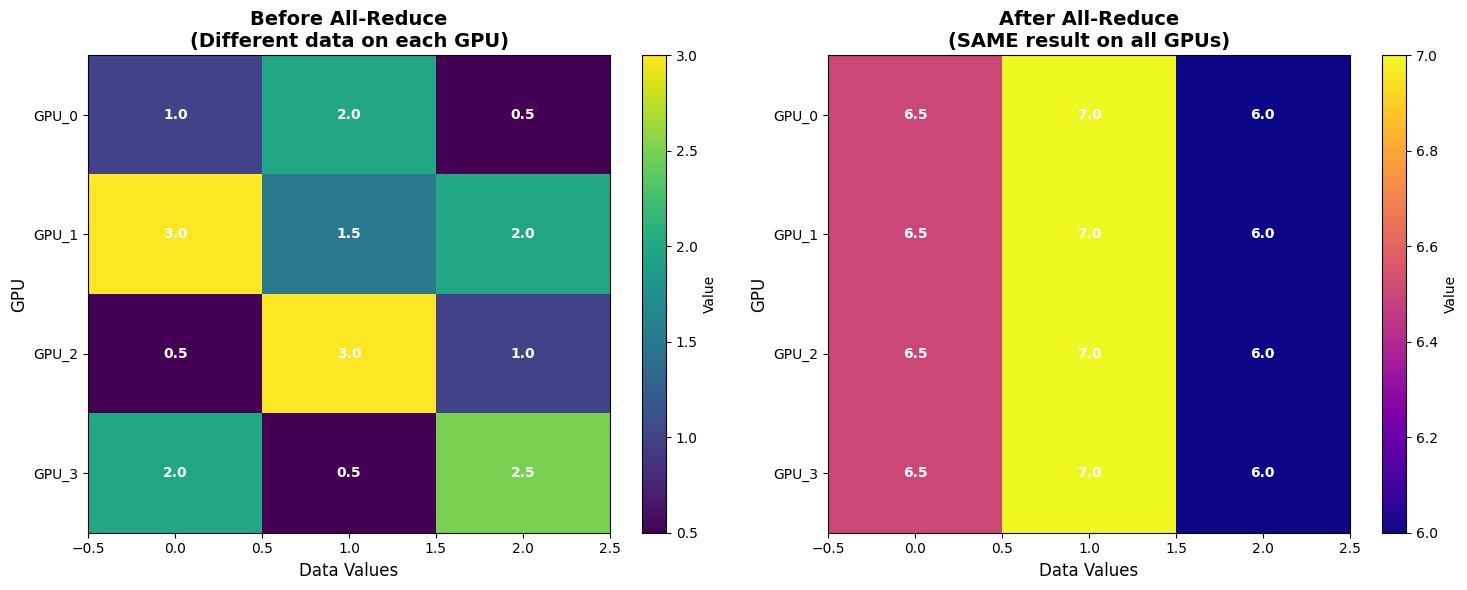

üéØ Key Point: Every GPU now has the IDENTICAL aggregated result!
üí° Use case: Synchronizing gradients in distributed training

üîÄ ALL-TO-ALL OPERATION
üì§ What each GPU sends to others:


‚ÜíGPU_0  ‚ÜíGPU_1  ‚ÜíGPU_2  ‚ÜíGPU_3
GPU_0_sends      10      20      30      40
GPU_1_sends      50      60      70      80
GPU_2_sends      90     100     110     120
GPU_3_sends     130     140     150     160

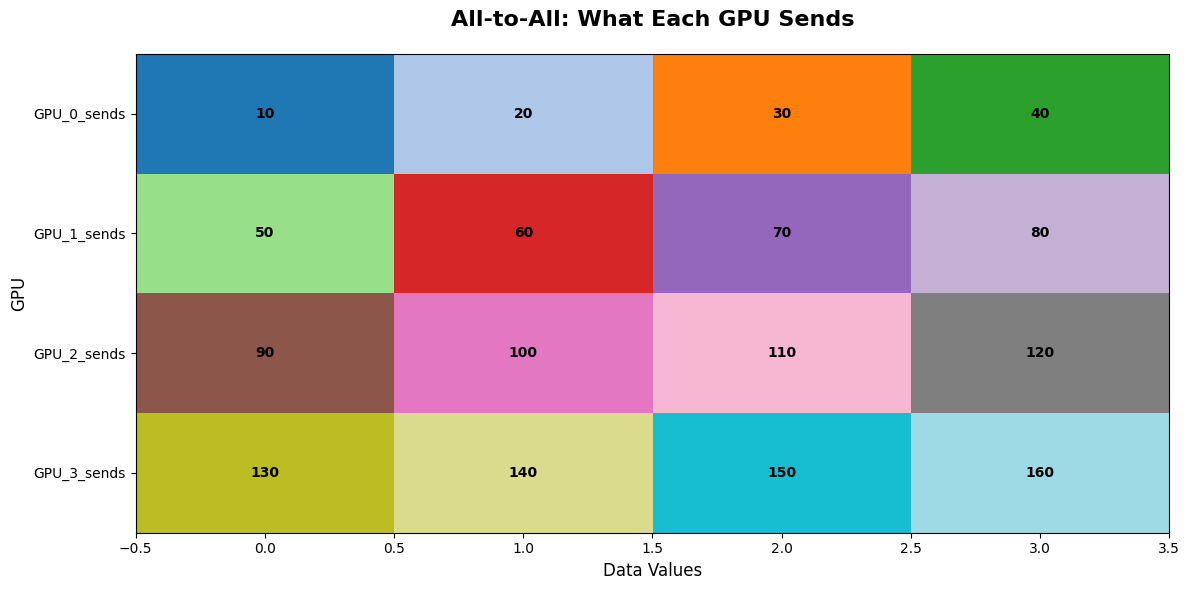

üì• What each GPU receives from others:


‚ÜêGPU_0  ‚ÜêGPU_1  ‚ÜêGPU_2  ‚ÜêGPU_3
GPU_0_receives      10      50      90     130
GPU_1_receives      20      60     100     140
GPU_2_receives      30      70     110     150
GPU_3_receives      40      80     120     160

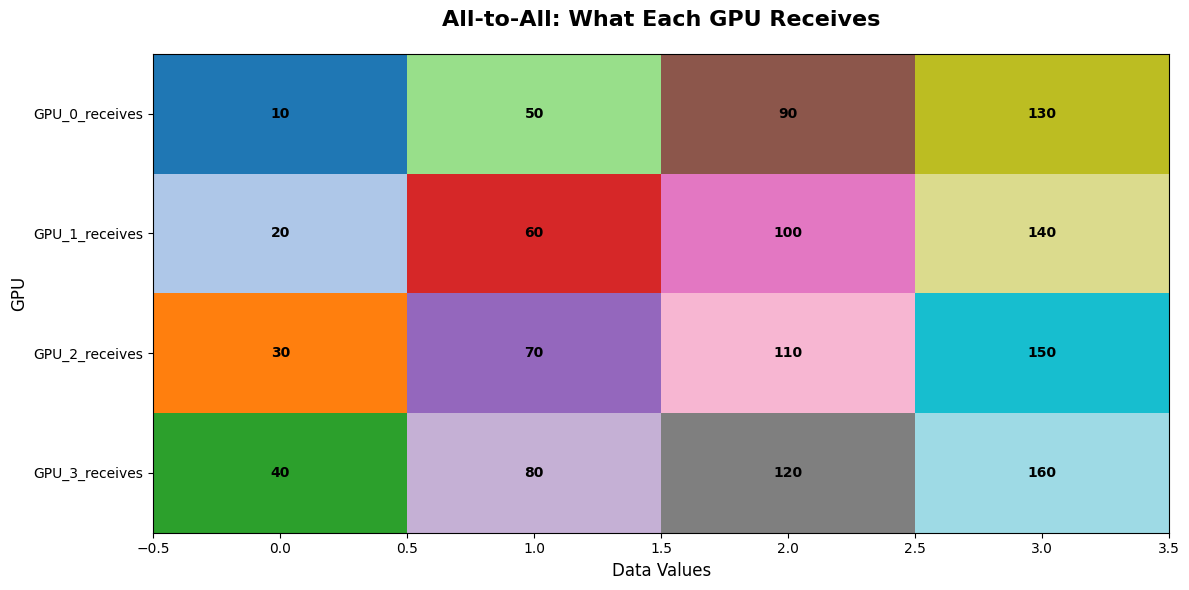

üéØ Key Point: Each GPU gets DIFFERENT data from all others!
üí° Use case: Tensor model parallelism, resharding data across GPUs

üî§ PARALLEL EMBEDDING: WHY ALL-REDUCE?
üìö Vocabulary split across GPUs:


GPU_0  GPU_1  GPU_2  GPU_3
0      0      4      8     12
1      1      5      9     13
2      2      6     10     14
3      3      7     11     15


üî¢ Input token sequence: [2, 6, 10, 14]

‚öôÔ∏è  Each GPU computes embeddings for tokens it owns:
üéØ Token assignments:
   Token_2 ‚Üí handled by GPU_0
   Token_6 ‚Üí handled by GPU_1
   Token_10 ‚Üí handled by GPU_2
   Token_14 ‚Üí handled by GPU_3

üìä Sparse embeddings (before all-reduce):


Dim_0  Dim_1  Dim_2  Dim_3
GPU_0    1.5    2.0    0.5    1.0
GPU_1    0.0    0.0    0.0    0.0
GPU_2    2.5    1.5    3.0    0.5
GPU_3    1.0    3.0    2.0    2.5

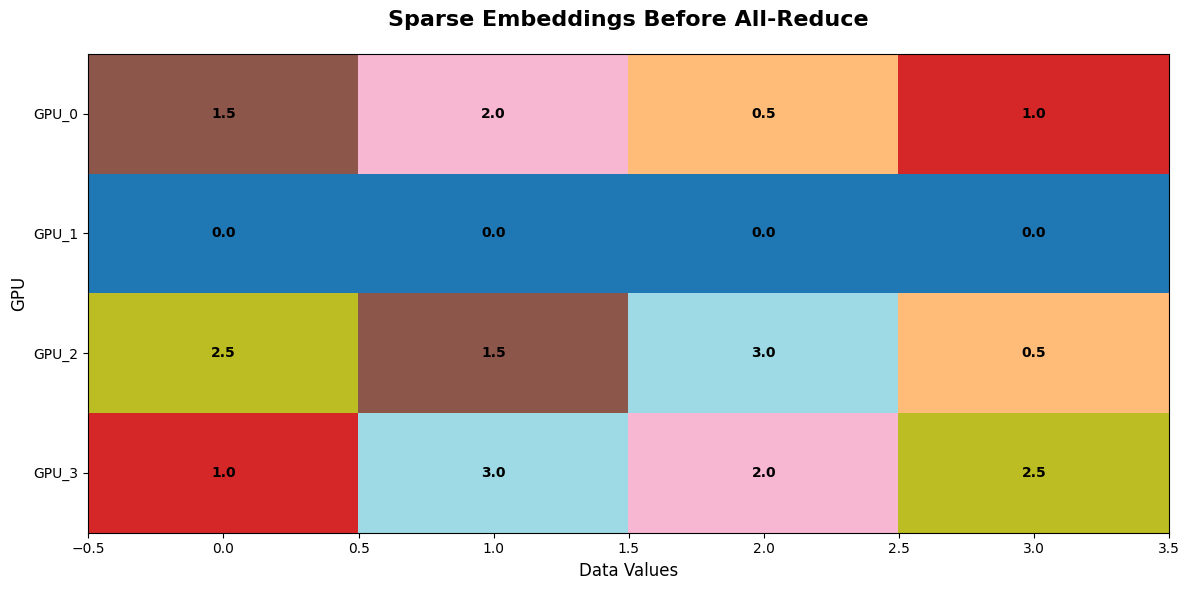


‚úÖ After ALL-REDUCE:
üéØ Complete embedding result on ALL GPUs: [5.0, 6.5, 5.5, 4.0]

üí° Why ALL-REDUCE is perfect for ParallelEmbedding:
   ‚úì Each GPU contributes sparse embeddings (zeros for tokens it doesn't own)
   ‚úì All-reduce SUMs these sparse contributions
   ‚úì Result: Complete dense embeddings on every GPU
   ‚úì Much more efficient than all-to-all data reshuffling!

üíª PYTORCH CODE EXAMPLES
üîÑ All-Reduce in PyTorch:
```python

# Gradient synchronization example
import torch.distributed as dist

# Each GPU has different gradients
local_gradients = torch.tensor([1.0, 2.0, 3.0])

# All-reduce: sum gradients across all GPUs
dist.all_reduce(local_gradients, op=dist.ReduceOp.SUM)

# Now local_gradients contains the sum from ALL GPUs
# Every GPU has the same result!
print(f"Synchronized gradients: {local_gradients}")

```

üîÄ All-to-All in PyTorch:
```python

# Tensor resharding example
import torch.distributed as dist

# Prepare data to send to each GPU
input_list =

Aspect                      All-Reduce  \
0  Communication Pattern      Many-to-Many ‚Üí Same Result   
1            Data Volume                    O(data_size)   
2          Network Usage  Optimized tree/ring algorithms   
3           Memory Usage                Constant per GPU   
4       Typical Use Case       Parameter sync, gradients   
5        Synchronization        All GPUs get same result   
6            Scalability  Excellent with good algorithms   

                          All-to-All  
0   Many-to-Many ‚Üí Different Results  
1            O(data_size √ó num_GPUs)  
2            Full mesh communication  
3               Grows with GPU count  
4  Tensor resharding, model parallel  
5       Each GPU gets different data  
6    Can become bandwidth bottleneck


üìã SUMMARY


üöÄ Try modifying the examples above to experiment with different scenarios!


In [1]:
# All-to-All vs All-Reduce Communication Patterns - Google Colab Version
# Run this in Google Colab for interactive visualizations!

import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML
import pandas as pd

print("üöÄ All-to-All vs All-Reduce Communication Patterns")
print("=" * 60)

# ================================
# VISUALIZATION HELPERS
# ================================

def create_gpu_visualization(data_dict, title, operation_type=""):
    """Create a nice visualization of GPU data"""
    plt.figure(figsize=(12, 6))

    if operation_type == "all_reduce":
        # Show before and after for all-reduce
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

        # Before all-reduce
        before_data = list(data_dict['before'].values())
        gpu_names = list(data_dict['before'].keys())

        im1 = ax1.imshow(before_data, cmap='viridis', aspect='auto')
        ax1.set_title('Before All-Reduce\n(Different data on each GPU)', fontsize=14, fontweight='bold')
        ax1.set_ylabel('GPU', fontsize=12)
        ax1.set_yticks(range(len(gpu_names)))
        ax1.set_yticklabels(gpu_names)
        ax1.set_xlabel('Data Values', fontsize=12)

        # Add value annotations
        for i in range(len(before_data)):
            for j in range(len(before_data[i])):
                ax1.text(j, i, f'{before_data[i][j]:.1f}',
                        ha='center', va='center', color='white', fontweight='bold')

        # After all-reduce
        after_data = [data_dict['after']] * len(gpu_names)
        im2 = ax2.imshow(after_data, cmap='plasma', aspect='auto')
        ax2.set_title('After All-Reduce\n(SAME result on all GPUs)', fontsize=14, fontweight='bold')
        ax2.set_ylabel('GPU', fontsize=12)
        ax2.set_yticks(range(len(gpu_names)))
        ax2.set_yticklabels(gpu_names)
        ax2.set_xlabel('Data Values', fontsize=12)

        # Add value annotations
        for i in range(len(after_data)):
            for j in range(len(after_data[i])):
                ax2.text(j, i, f'{after_data[i][j]:.1f}',
                        ha='center', va='center', color='white', fontweight='bold')

        plt.colorbar(im1, ax=ax1, label='Value')
        plt.colorbar(im2, ax=ax2, label='Value')

    else:
        # Single plot for other visualizations
        data_matrix = []
        labels = []
        for key, values in data_dict.items():
            if isinstance(values, list):
                data_matrix.append(values)
                labels.append(key)

        im = plt.imshow(data_matrix, cmap='tab20', aspect='auto')
        plt.title(title, fontsize=16, fontweight='bold', pad=20)
        plt.ylabel('GPU', fontsize=12)
        plt.xlabel('Data Values', fontsize=12)
        plt.yticks(range(len(labels)), labels)

        # Add value annotations
        for i in range(len(data_matrix)):
            for j in range(len(data_matrix[i])):
                plt.text(j, i, f'{data_matrix[i][j]}',
                        ha='center', va='center', fontweight='bold')

    plt.tight_layout()
    plt.show()

# ================================
# ALL-REDUCE OPERATION
# ================================

def demonstrate_all_reduce():
    """
    All-Reduce: Each GPU has different data ‚Üí All GPUs get the SAME result
    """
    print("\nüîÑ ALL-REDUCE OPERATION")
    print("=" * 40)

    # Simulate 4 GPUs with different initial gradients
    gpu_gradients = {
        'GPU_0': [1.0, 2.0, 0.5],
        'GPU_1': [3.0, 1.5, 2.0],
        'GPU_2': [0.5, 3.0, 1.0],
        'GPU_3': [2.0, 0.5, 2.5]
    }

    print("üìä Initial gradients on each GPU:")
    df_before = pd.DataFrame(gpu_gradients).T
    df_before.columns = ['Param_1', 'Param_2', 'Param_3']
    display(df_before)

    # Compute all-reduce (SUM)
    result = []
    for i in range(len(list(gpu_gradients.values())[0])):
        total = sum(gpu_data[i] for gpu_data in gpu_gradients.values())
        result.append(total)

    print(f"\n‚úÖ After ALL-REDUCE (SUM):")
    print(f"üìã Result on ALL GPUs: {result}")

    # Create visualization
    viz_data = {
        'before': gpu_gradients,
        'after': result
    }
    create_gpu_visualization(viz_data, "All-Reduce: Gradient Synchronization", "all_reduce")

    print("üéØ Key Point: Every GPU now has the IDENTICAL aggregated result!")
    print("üí° Use case: Synchronizing gradients in distributed training")

    return result

# ================================
# ALL-TO-ALL OPERATION
# ================================

def demonstrate_all_to_all():
    """
    All-to-All: Each GPU sends DIFFERENT data to every other GPU
    """
    print("\nüîÄ ALL-TO-ALL OPERATION")
    print("=" * 40)

    # Each GPU has data to send to each other GPU
    print("üì§ What each GPU sends to others:")

    # Simulate tensor sharding - each GPU sends different chunks
    send_data = {
        'GPU_0_sends': [10, 20, 30, 40],  # to GPU_0, GPU_1, GPU_2, GPU_3
        'GPU_1_sends': [50, 60, 70, 80],
        'GPU_2_sends': [90, 100, 110, 120],
        'GPU_3_sends': [130, 140, 150, 160]
    }

    df_sends = pd.DataFrame(send_data).T
    df_sends.columns = ['‚ÜíGPU_0', '‚ÜíGPU_1', '‚ÜíGPU_2', '‚ÜíGPU_3']
    display(df_sends)

    create_gpu_visualization(send_data, "All-to-All: What Each GPU Sends")

    # Show what each GPU receives
    print("üì• What each GPU receives from others:")

    receive_data = {
        'GPU_0_receives': [10, 50, 90, 130],    # from GPU_0, GPU_1, GPU_2, GPU_3
        'GPU_1_receives': [20, 60, 100, 140],
        'GPU_2_receives': [30, 70, 110, 150],
        'GPU_3_receives': [40, 80, 120, 160]
    }

    df_receives = pd.DataFrame(receive_data).T
    df_receives.columns = ['‚ÜêGPU_0', '‚ÜêGPU_1', '‚ÜêGPU_2', '‚ÜêGPU_3']
    display(df_receives)

    create_gpu_visualization(receive_data, "All-to-All: What Each GPU Receives")

    print("üéØ Key Point: Each GPU gets DIFFERENT data from all others!")
    print("üí° Use case: Tensor model parallelism, resharding data across GPUs")

# ================================
# PARALLEL EMBEDDING VISUALIZATION
# ================================

def demonstrate_parallel_embedding():
    """
    Show why ParallelEmbedding uses All-Reduce, not All-to-All
    """
    print("\nüî§ PARALLEL EMBEDDING: WHY ALL-REDUCE?")
    print("=" * 50)

    # Setup
    vocab_size = 16
    embedding_dim = 4

    print("üìö Vocabulary split across GPUs:")
    gpu_vocab = {
        'GPU_0': list(range(0, 4)),      # tokens 0-3
        'GPU_1': list(range(4, 8)),      # tokens 4-7
        'GPU_2': list(range(8, 12)),     # tokens 8-11
        'GPU_3': list(range(12, 16))     # tokens 12-15
    }

    df_vocab = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in gpu_vocab.items()]))
    display(df_vocab)

    # Input sequence
    input_tokens = [2, 6, 10, 14]
    print(f"\nüî¢ Input token sequence: {input_tokens}")

    # Each GPU computes embeddings for its tokens only
    print("\n‚öôÔ∏è  Each GPU computes embeddings for tokens it owns:")

    # Simulate sparse embeddings (simplified)
    embeddings = {
        'GPU_0': [1.5, 2.0, 0.5, 1.0],  # embedding for token 2
        'GPU_1': [0.0, 0.0, 0.0, 0.0],  # no tokens for GPU_1 in this batch
        'GPU_2': [2.5, 1.5, 3.0, 0.5],  # embedding for token 10
        'GPU_3': [1.0, 3.0, 2.0, 2.5]   # embedding for token 14
    }

    # Show which GPU handles which token
    token_assignment = {}
    for token in input_tokens:
        for gpu, token_range in gpu_vocab.items():
            if token in token_range:
                token_assignment[f'Token_{token}'] = gpu
                break

    print("üéØ Token assignments:")
    for token, gpu in token_assignment.items():
        print(f"   {token} ‚Üí handled by {gpu}")

    # Visualize sparse embeddings
    df_embeddings = pd.DataFrame(embeddings).T
    df_embeddings.columns = [f'Dim_{i}' for i in range(embedding_dim)]
    print(f"\nüìä Sparse embeddings (before all-reduce):")
    display(df_embeddings)

    create_gpu_visualization(embeddings, "Sparse Embeddings Before All-Reduce")

    # All-reduce to get complete embeddings
    final_embeddings = []
    for dim in range(embedding_dim):
        total = sum(embeddings[gpu][dim] for gpu in embeddings.keys())
        final_embeddings.append(total)

    print(f"\n‚úÖ After ALL-REDUCE:")
    print(f"üéØ Complete embedding result on ALL GPUs: {final_embeddings}")

    # Show why all-reduce is perfect here
    print(f"\nüí° Why ALL-REDUCE is perfect for ParallelEmbedding:")
    print(f"   ‚úì Each GPU contributes sparse embeddings (zeros for tokens it doesn't own)")
    print(f"   ‚úì All-reduce SUMs these sparse contributions")
    print(f"   ‚úì Result: Complete dense embeddings on every GPU")
    print(f"   ‚úì Much more efficient than all-to-all data reshuffling!")

# ================================
# PYTORCH CODE EXAMPLES
# ================================

def show_pytorch_examples():
    """Show actual PyTorch distributed code"""

    print("\nüíª PYTORCH CODE EXAMPLES")
    print("=" * 40)

    # All-reduce example
    print("üîÑ All-Reduce in PyTorch:")
    code_allreduce = '''
# Gradient synchronization example
import torch.distributed as dist

# Each GPU has different gradients
local_gradients = torch.tensor([1.0, 2.0, 3.0])

# All-reduce: sum gradients across all GPUs
dist.all_reduce(local_gradients, op=dist.ReduceOp.SUM)

# Now local_gradients contains the sum from ALL GPUs
# Every GPU has the same result!
print(f"Synchronized gradients: {local_gradients}")
'''

    print("```python")
    print(code_allreduce)
    print("```")

    # All-to-all example
    print("\nüîÄ All-to-All in PyTorch:")
    code_alltoall = '''
# Tensor resharding example
import torch.distributed as dist

# Prepare data to send to each GPU
input_list = [
    torch.tensor([1, 2]),    # send to GPU 0
    torch.tensor([3, 4]),    # send to GPU 1
    torch.tensor([5, 6]),    # send to GPU 2
    torch.tensor([7, 8])     # send to GPU 3
]

# Prepare containers for received data
output_list = [torch.empty(2) for _ in range(4)]

# All-to-all: each GPU sends different data to each other GPU
dist.all_to_all(output_list, input_list)

# Now output_list contains different data received from each GPU
'''

    print("```python")
    print(code_alltoall)
    print("```")

    # ParallelEmbedding example
    print("\nüî§ ParallelEmbedding All-Reduce:")
    code_embedding = '''
# From DeepSeek or similar implementations
class ParallelEmbedding(nn.Module):
    def forward(self, input_ids):
        # Each GPU handles subset of vocabulary
        local_embeddings = self.embedding(input_ids)  # sparse result

        # All-reduce to get complete embeddings on all GPUs
        dist.all_reduce(local_embeddings, op=dist.ReduceOp.SUM)

        return local_embeddings  # now complete on all GPUs
'''

    print("```python")
    print(code_embedding)
    print("```")

# ================================
# PERFORMANCE COMPARISON
# ================================

def show_performance_comparison():
    """Compare performance characteristics"""

    print("\n‚ö° PERFORMANCE COMPARISON")
    print("=" * 40)

    comparison_data = {
        'Aspect': [
            'Communication Pattern',
            'Data Volume',
            'Network Usage',
            'Memory Usage',
            'Typical Use Case',
            'Synchronization',
            'Scalability'
        ],
        'All-Reduce': [
            'Many-to-Many ‚Üí Same Result',
            'O(data_size)',
            'Optimized tree/ring algorithms',
            'Constant per GPU',
            'Parameter sync, gradients',
            'All GPUs get same result',
            'Excellent with good algorithms'
        ],
        'All-to-All': [
            'Many-to-Many ‚Üí Different Results',
            'O(data_size √ó num_GPUs)',
            'Full mesh communication',
            'Grows with GPU count',
            'Tensor resharding, model parallel',
            'Each GPU gets different data',
            'Can become bandwidth bottleneck'
        ]
    }

    df_comparison = pd.DataFrame(comparison_data)
    display(df_comparison)

# ================================
# MAIN EXECUTION
# ================================

def main():
    """Run all demonstrations"""

    print("üéØ INTERACTIVE DEMONSTRATION")
    print("This notebook shows the key differences between All-Reduce and All-to-All")
    print("with visual examples and real PyTorch code!")

    # Run all demonstrations
    demonstrate_all_reduce()
    demonstrate_all_to_all()
    demonstrate_parallel_embedding()
    show_pytorch_examples()
    show_performance_comparison()

    print("\n" + "="*60)
    print("üìã SUMMARY")
    print("="*60)

    summary_html = """
    <div style="background-color: #f0f8ff; padding: 20px; border-radius: 10px; margin: 10px 0;">
    <h3>üîÑ All-Reduce</h3>
    <ul>
        <li><strong>Pattern:</strong> Different input ‚Üí Same output on all GPUs</li>
        <li><strong>Use case:</strong> Gradient synchronization, parameter averaging</li>
        <li><strong>Example:</strong> Each GPU has different gradients ‚Üí All get summed gradients</li>
    </ul>
    </div>

    <div style="background-color: #f0fff0; padding: 20px; border-radius: 10px; margin: 10px 0;">
    <h3>üîÄ All-to-All</h3>
    <ul>
        <li><strong>Pattern:</strong> Redistribute data ‚Üí Different output on each GPU</li>
        <li><strong>Use case:</strong> Tensor resharding, model parallelism</li>
        <li><strong>Example:</strong> Reshape tensor across different dimension splits</li>
    </ul>
    </div>

    <div style="background-color: #fff8f0; padding: 20px; border-radius: 10px; margin: 10px 0;">
    <h3>üî§ ParallelEmbedding ‚Üí All-Reduce</h3>
    <ul>
        <li><strong>Why not All-to-All?</strong> We want the <em>same</em> complete result on all GPUs</li>
        <li><strong>How it works:</strong> Each GPU computes sparse embeddings ‚Üí All-reduce sums them</li>
        <li><strong>Efficiency:</strong> Much better than reshuffling complete embedding tables</li>
    </ul>
    </div>
    """

    display(HTML(summary_html))

    print("üöÄ Try modifying the examples above to experiment with different scenarios!")

# Run the demonstration
if __name__ == "__main__":
    main()

In [ ]:
# Run this in Colab:
!git config --global user.name "Your GitHub Username"
!git config --global user.email "your-email@github.com"

# Clone your repo
!git clone https://github.com/yourusername/yourrepo.git

# Copy the notebook
!cp "/content/your_notebook.ipynb" "/content/yourrepo/"

# Commit and push
%cd /content/yourrepo
!git add .
!git commit -m "Add all-reduce vs all-to-all demo"
!git push